In [645]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from suntime import Sun
from pysolar.solar import *
from pysolar.radiation import *

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from flaml import AutoML

from warnings import filterwarnings
filterwarnings('ignore')


In [646]:
from pandas.io.parsers import read_csv

generation_df = read_csv("generation.csv",delimiter=";",decimal=",")
temperature_df = read_csv("temperature.csv",delimiter=";",decimal=",")
sample_submission_df = read_csv("sample_submission.csv")
angle_df = read_csv("angle.csv")

In [647]:
generation_df

,DateTime,Generation
0,01Jan2019 0:00:00,0.000000
1,01Jan2019 1:00:00,0.000000
2,01Jan2019 2:00:00,0.000008
3,01Jan2019 3:00:00,0.000000
4,01Jan2019 4:00:00,0.000008
...,...,...
26299,NaN,NaN
26300,NaN,NaN
26301,NaN,NaN
26302,NaN,NaN


In [648]:
temperature_df

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,01Jan2019 0:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
1,01Jan2019 1:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2,01Jan2019 2:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
3,01Jan2019 3:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
4,01Jan2019 4:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5
...,...,...,...,...,...,...,...,...
26394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [649]:
df = pd.concat([generation_df,temperature_df.drop("DateTime",axis=1)],axis=1)

In [650]:
df

,DateTime,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,01Jan2019 0:00:00,0.000000,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
1,01Jan2019 1:00:00,0.000000,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2,01Jan2019 2:00:00,0.000008,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
3,01Jan2019 3:00:00,0.000000,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
4,01Jan2019 4:00:00,0.000008,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5
...,...,...,...,...,...,...,...,...,...
26394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [651]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26399 entries, 0 to 26398
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DateTime             25560 non-null  object 
 1   Generation           25560 non-null  float64
 2   AirTemperature       26304 non-null  float64
 3   ComfortTemperature   26304 non-null  float64
 4   RelativeHumidity     26304 non-null  float64
 5   WindSpeed            26304 non-null  float64
 6   WindDirection        26304 non-null  float64
 7   WWCode               20050 non-null  float64
 8   EffectiveCloudCover  26304 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


In [652]:
df["DateTime"] = pd.to_datetime(df["DateTime"])

In [653]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Generation,25560.0,89.724239,126.180117,0.0,0.0,4.317082,168.498464,456.319322
AirTemperature,26304.0,13.741522,9.379876,-13.1,6.0,13.400000,21.000000,39.000000
ComfortTemperature,26304.0,13.239397,9.767058,-19.3,5.1,13.000000,21.200000,37.200000
RelativeHumidity,26304.0,54.352832,22.566688,1.6,36.6,55.100000,72.500000,100.000000
WindSpeed,26304.0,1.655931,1.353196,0.0,0.5,1.500000,2.600000,13.400000
WindDirection,26304.0,87.463960,100.762932,0.0,20.0,30.000000,170.000000,360.000000
WWCode,20050.0,13.095711,24.471306,0.0,0.0,3.000000,10.000000,99.000000
EffectiveCloudCover,26304.0,2.614051,2.497609,0.0,0.0,2.100000,5.000000,8.000000


In [654]:
df.isnull().sum()

DateTime                839
Generation              839
AirTemperature           95
ComfortTemperature       95
RelativeHumidity         95
WindSpeed                95
WindDirection            95
WWCode                 6349
EffectiveCloudCover      95
dtype: int64

In [655]:
df["WWCode"].fillna(df["WWCode"].mean(),inplace=True)

In [656]:
df.dropna(inplace=True)

In [657]:
df.isnull().sum()

DateTime               0
Generation             0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
dtype: int64

In [658]:
def timeSeriesConverter(df):

    df["Hours"] = df["DateTime"].dt.hour
    df["Days"] = df["DateTime"].dt.day
    df["Months"] = df["DateTime"].dt.month
    df["Years"] = df["DateTime"].dt.year

    df["Quarter"] = df["DateTime"].dt.quarter
    df["Day of Week"] = df["DateTime"].dt.dayofweek
    df["Day of Year"] = df["DateTime"].dt.dayofyear
    

    return df

In [659]:
df = timeSeriesConverter(df)

In [660]:
df = df.join(angle_df.set_index("Months"), on="Months")

In [661]:
df

,DateTime,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hours,Days,Months,Years,Quarter,Day of Week,Day of Year,Angle
0,2019-01-01 00:00:00,0.000000,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,1,1,2019,1,1,1,64
1,2019-01-01 01:00:00,0.000000,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,1,1,2019,1,1,1,64
2,2019-01-01 02:00:00,0.000008,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,2,1,1,2019,1,1,1,64
3,2019-01-01 03:00:00,0.000000,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,3,1,1,2019,1,1,1,64
4,2019-01-01 04:00:00,0.000008,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,4,1,1,2019,1,1,1,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,2021-11-30 19:00:00,0.000000,7.1,5.2,76.8,3.1,220.0,25.0,6.0,19,30,11,2021,4,1,334,62
25556,2021-11-30 20:00:00,0.000000,7.1,5.7,75.2,2.1,250.0,80.0,6.0,20,30,11,2021,4,1,334,62
25557,2021-11-30 21:00:00,0.000000,5.8,3.1,83.4,4.1,280.0,80.0,7.0,21,30,11,2021,4,1,334,62
25558,2021-11-30 22:00:00,0.000000,5.0,3.3,81.0,2.1,240.0,60.0,6.0,22,30,11,2021,4,1,334,62


<AxesSubplot:>

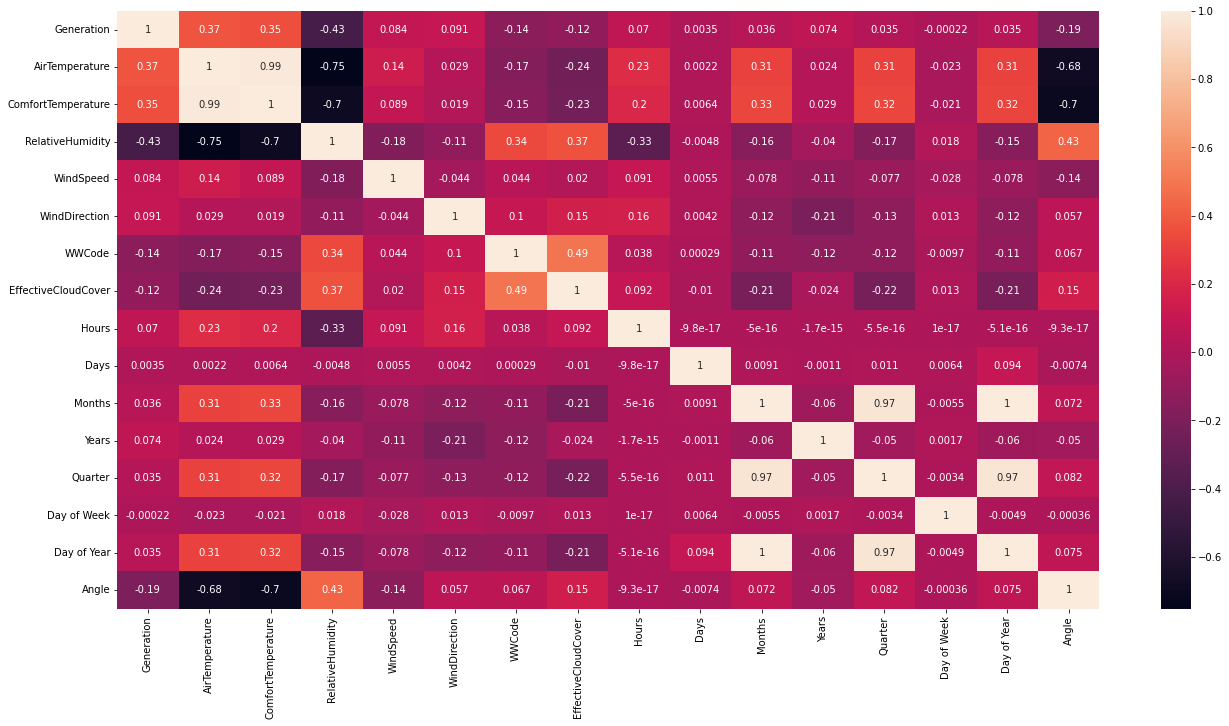

In [662]:
plt.figure(figsize=(22,11))
sns.heatmap(df.corr(),annot=True)

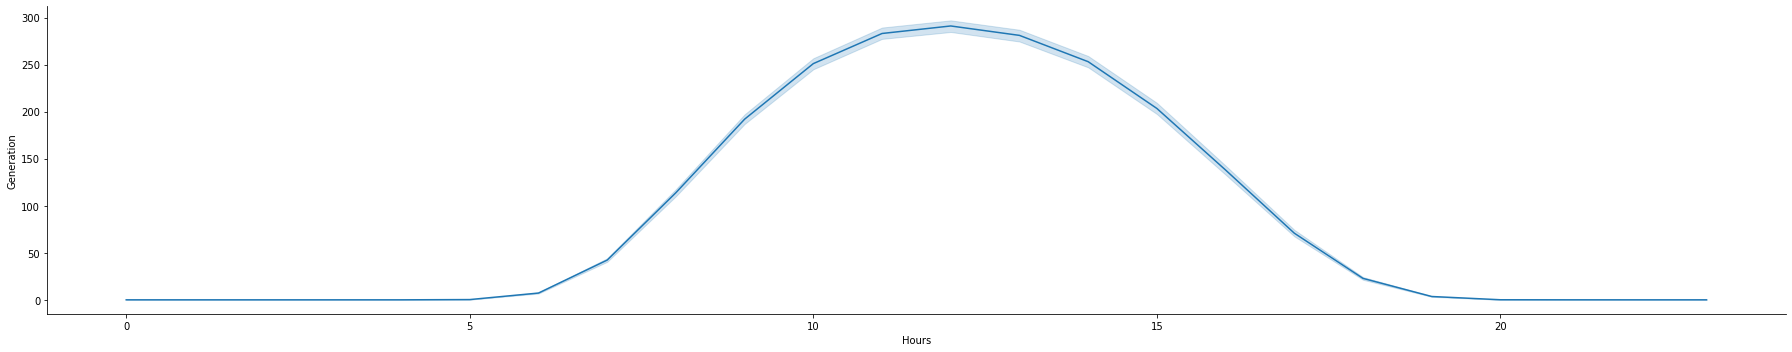

In [663]:
sns.relplot(data=df,x="Hours",y="Generation",kind="line",height=5,aspect=5)

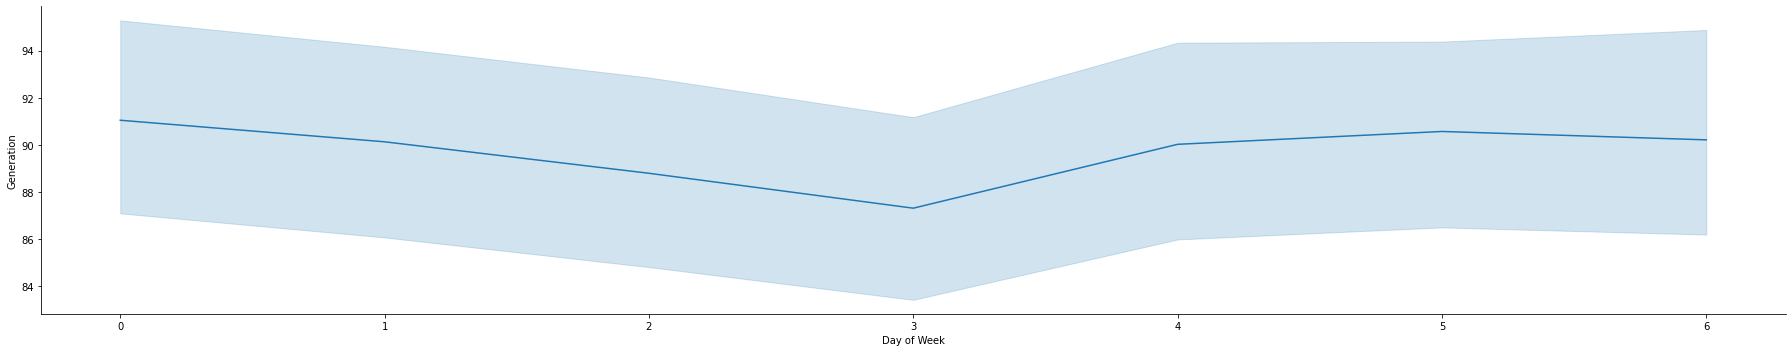

In [664]:
sns.relplot(data=df,x="Day of Week",y="Generation",kind="line",height=5,aspect=5)

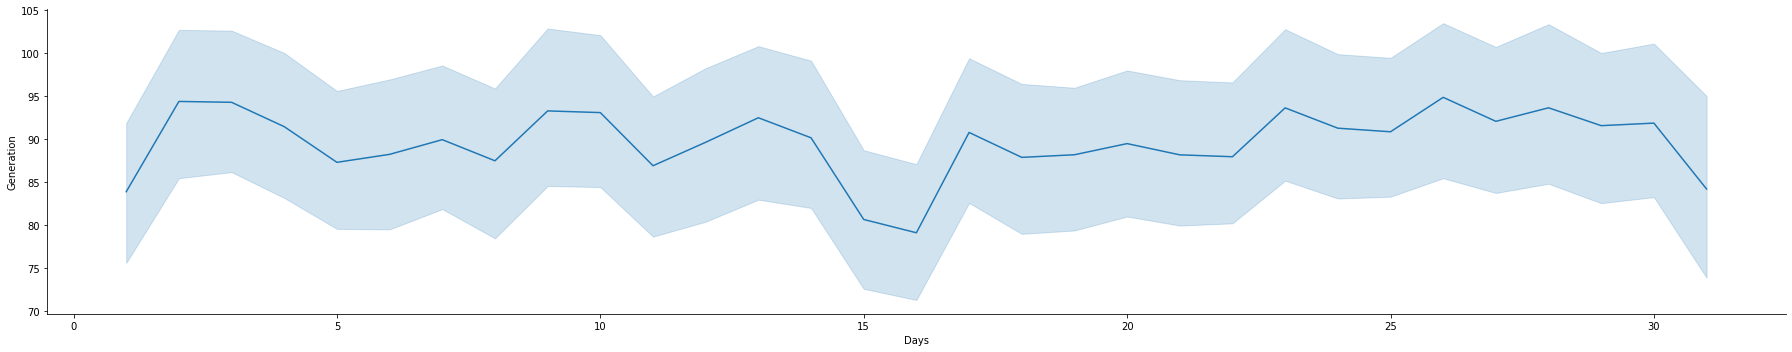

In [665]:
sns.relplot(data=df,x="Days",y="Generation",kind="line",height=5,aspect=5)

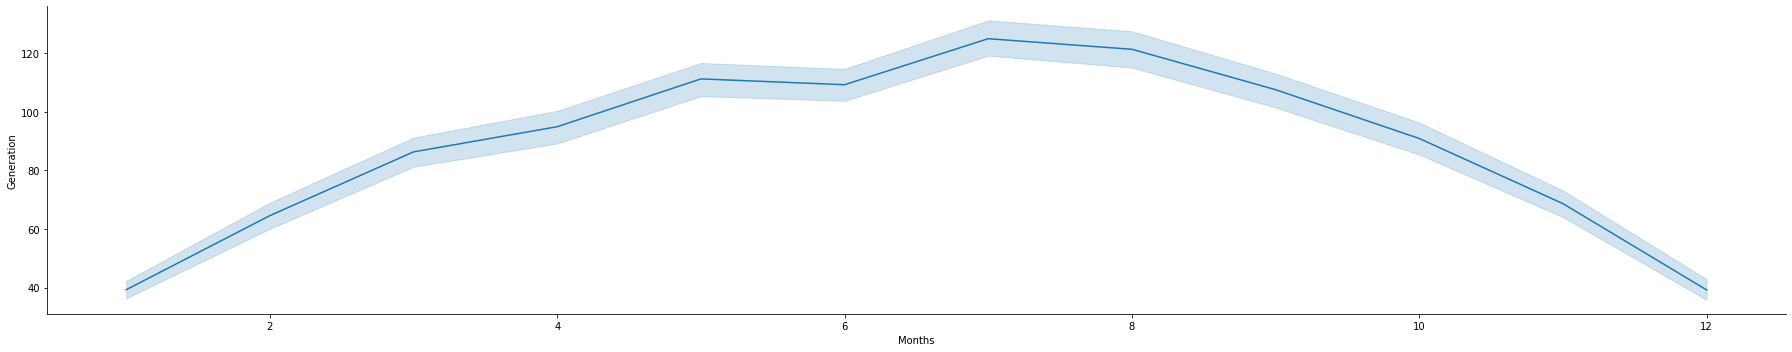

In [666]:
sns.relplot(data=df,x="Months",y="Generation",kind="line",height=5,aspect=5)

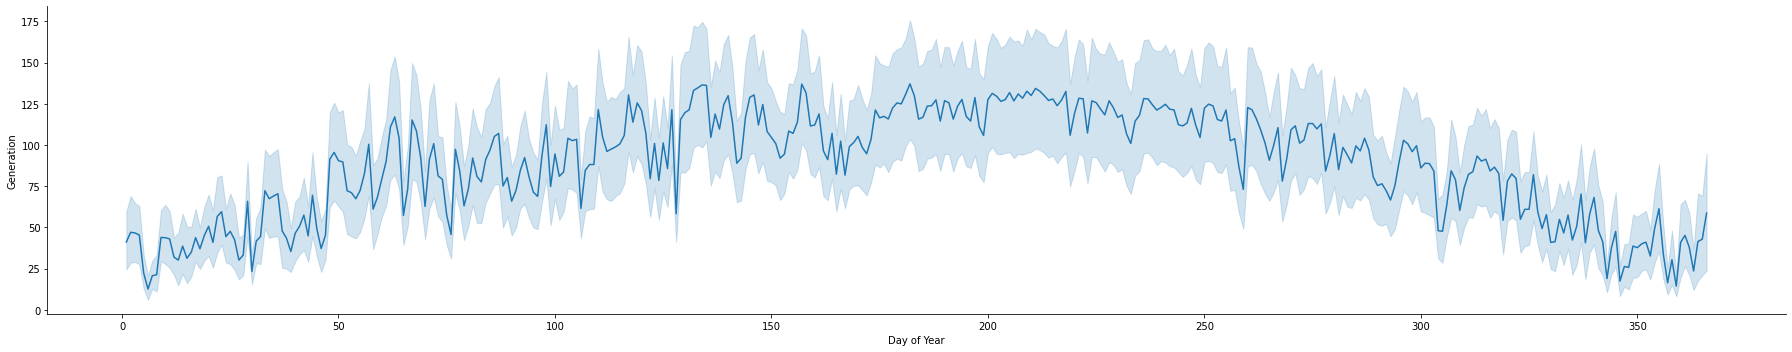

In [667]:
sns.relplot(data=df,x="Day of Year",y="Generation",kind="line",height=5,aspect=5)

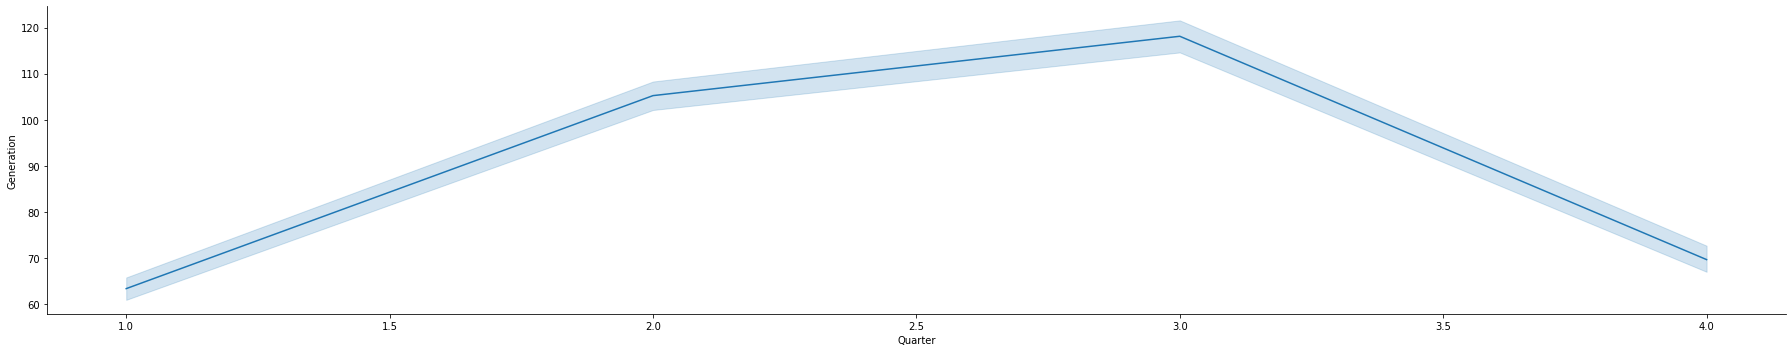

In [668]:
sns.relplot(data=df,x="Quarter",y="Generation",kind="line",height=5,aspect=5)

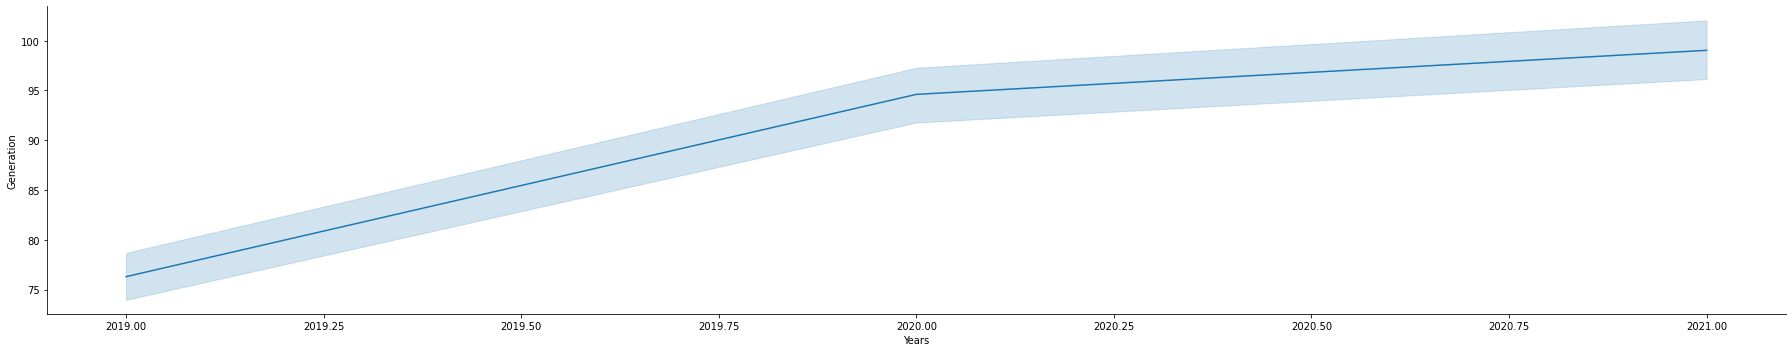

In [669]:
sns.relplot(data=df,x="Years",y="Generation",kind="line",height=5,aspect=5)

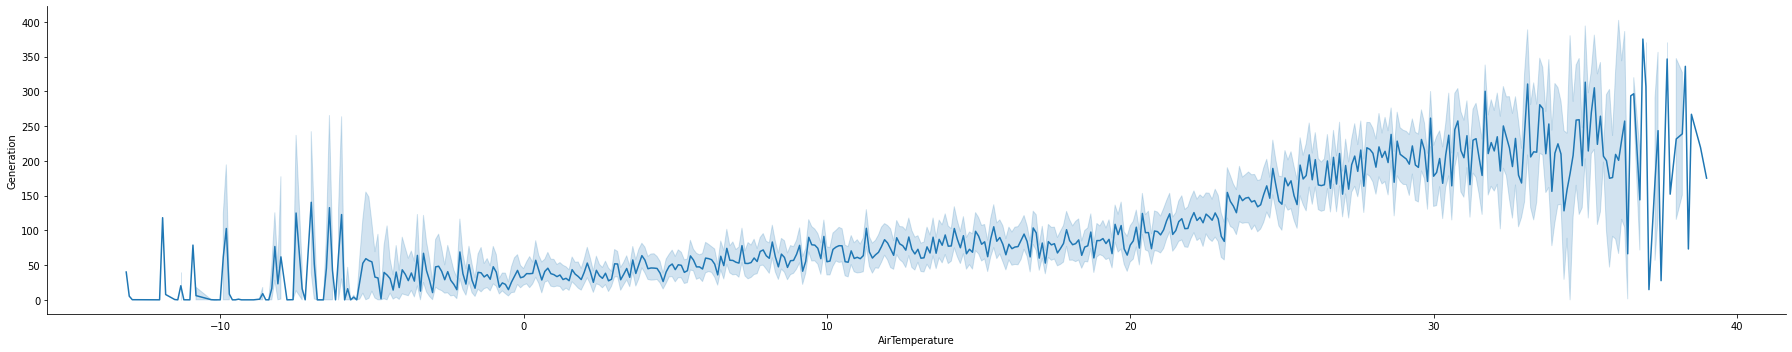

In [670]:
sns.relplot(data=df,x="AirTemperature",y="Generation",kind="line",height=5,aspect=5)

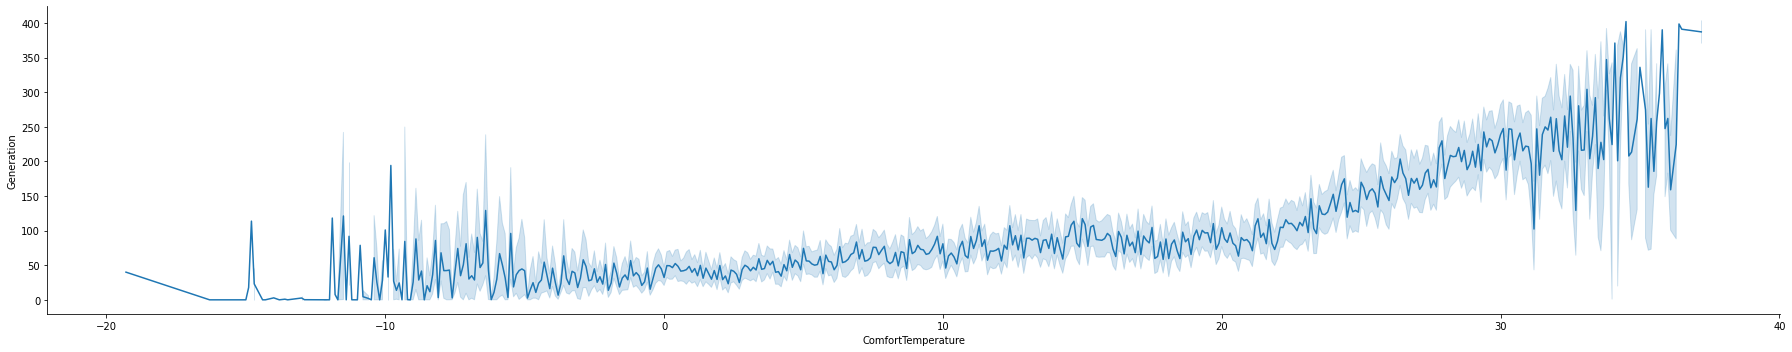

In [671]:
sns.relplot(data=df,x="ComfortTemperature",y="Generation",kind="line",height=5,aspect=5)

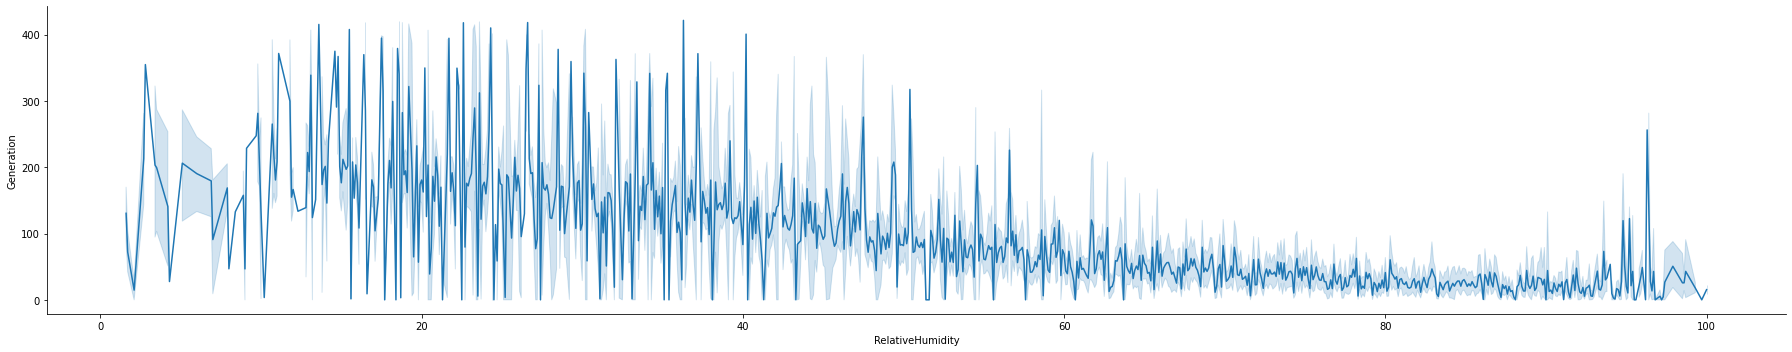

In [672]:
sns.relplot(data=df,x="RelativeHumidity",y="Generation",kind="line",height=5,aspect=5)

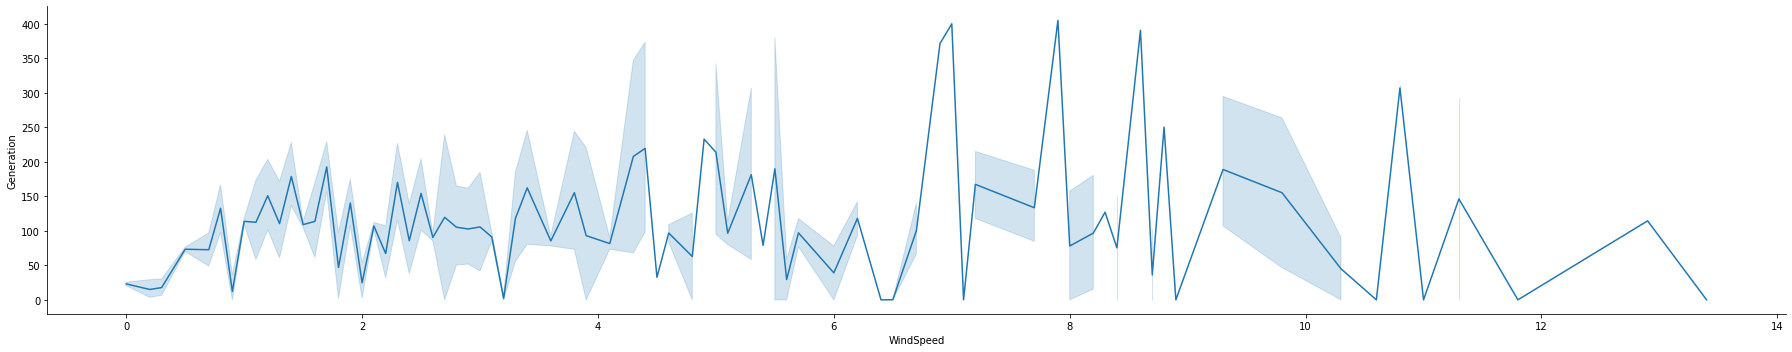

In [673]:
sns.relplot(data=df,x="WindSpeed",y="Generation",kind="line",height=5,aspect=5)

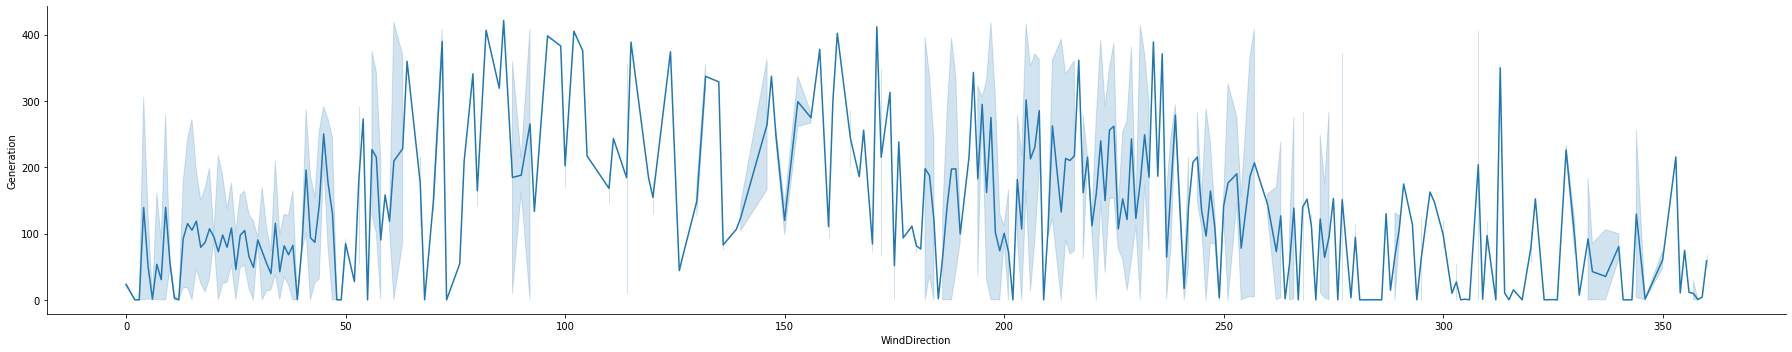

In [674]:
sns.relplot(data=df,x="WindDirection",y="Generation",kind="line",height=5,aspect=5)

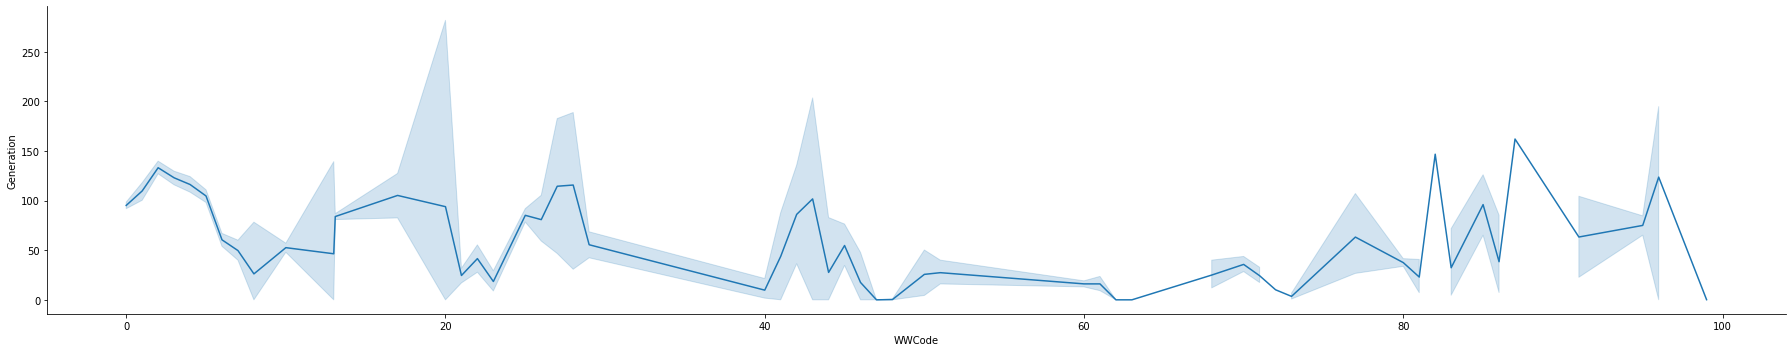

In [675]:
sns.relplot(data=df,x="WWCode",y="Generation",kind="line",height=5,aspect=5)

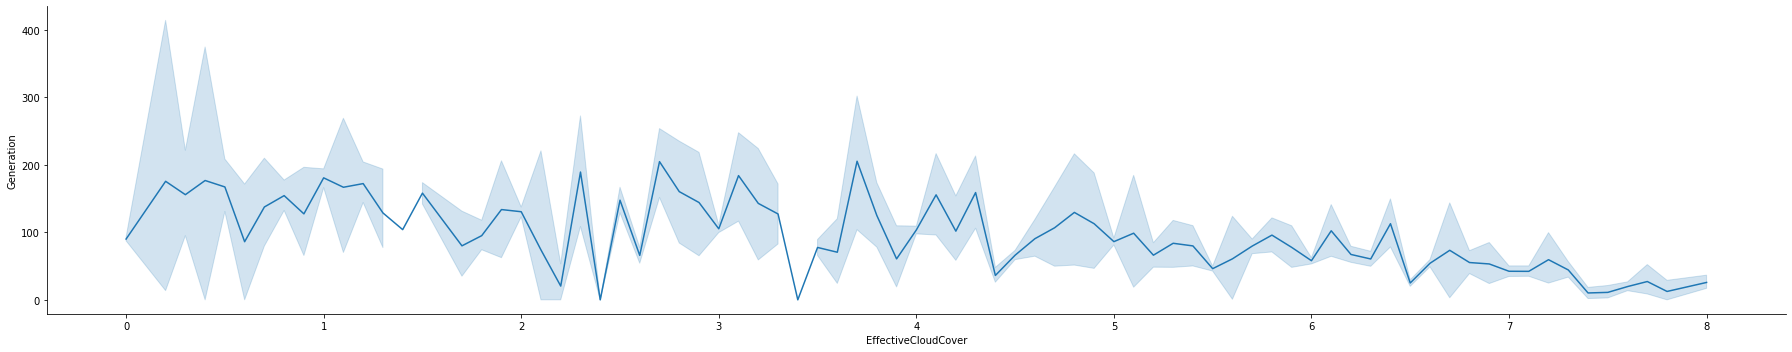

In [676]:
sns.relplot(data=df,x="EffectiveCloudCover",y="Generation",kind="line",height=5,aspect=5)

In [677]:
def dayNight(df,latitude,longitude):
    
    sun = Sun(latitude,longitude)
    df["DayTime"] = df["DateTime"].apply(lambda x: sun.get_local_sunrise_time(x).hour <= x.hour <= sun.get_local_sunset_time(x).hour)

    return df

In [678]:
df = dayNight(df,39.925533,32.866287)

In [679]:
def getSun(df,latitude,longitude,timezone):
    
    df['DateTime'] = df['DateTime'].dt.tz_localize(tz=timezone)

    df["Altitude"] = df["DateTime"].apply(lambda x:get_altitude(latitude,longitude,x.to_pydatetime()))
    df["Azimuth"] = df["DateTime"].apply(lambda x:get_azimuth(latitude,longitude,x.to_pydatetime()))
    df["Radiation"] = df["DateTime"].apply(lambda x:radiation.get_radiation_direct(x.to_pydatetime(),get_altitude(latitude,longitude,x.to_pydatetime())))

    return df

In [680]:
df = getSun(df,39.925533,32.866287,'Etc/GMT-3')

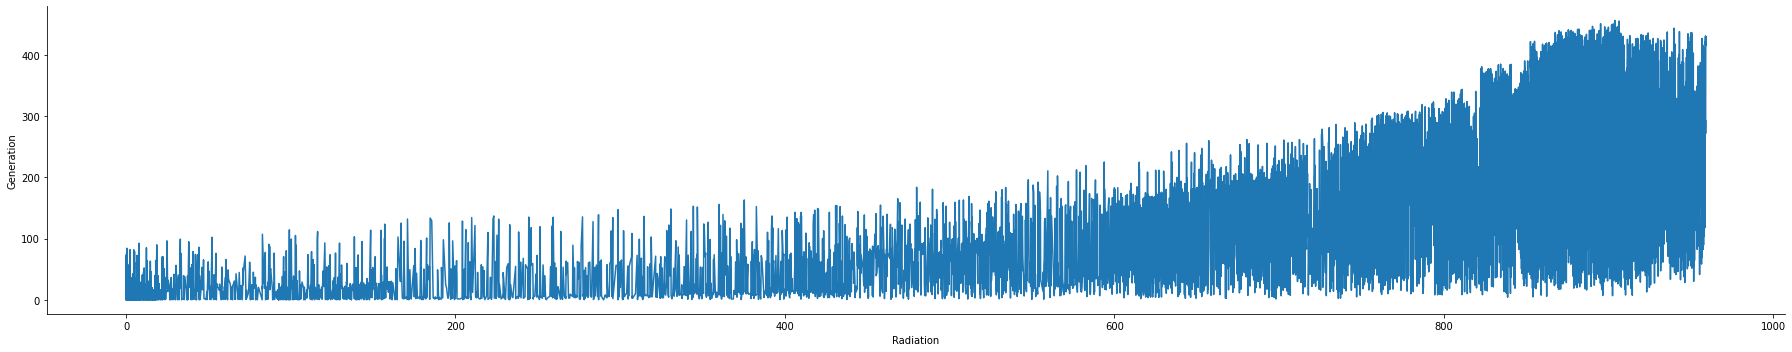

In [681]:
sns.relplot(data=df,x="Radiation",y="Generation",kind="line",height=5,aspect=5)

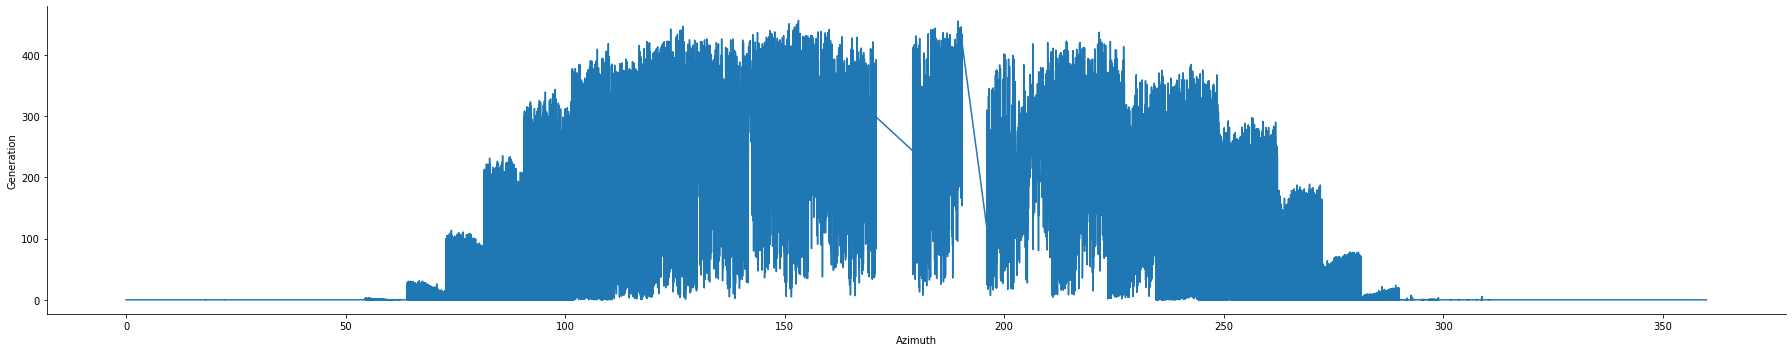

In [682]:
sns.relplot(data=df,x="Azimuth",y="Generation",kind="line",height=5,aspect=5)

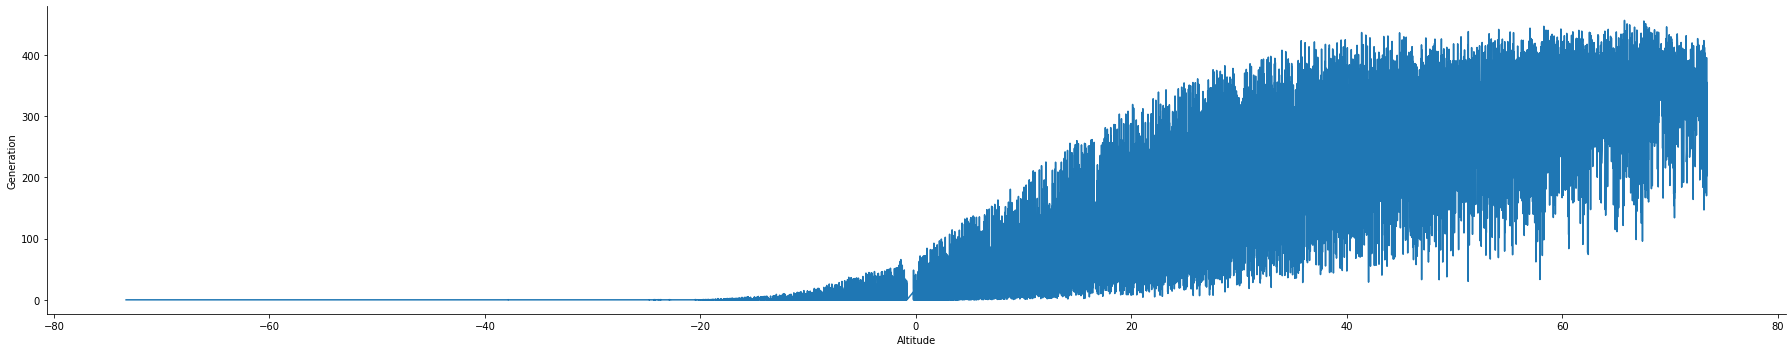

In [683]:
sns.relplot(data=df,x="Altitude",y="Generation",kind="line",height=5,aspect=5)

In [684]:
df = df.fillna(0)

In [685]:
x = df.drop(["Generation","DateTime"],axis=1)
y = df["Generation"]

In [686]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=200)

In [687]:
X_train

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hours,Days,Months,Years,Quarter,Day of Week,Day of Year,Angle,DayTime,Altitude,Azimuth,Radiation
22886,27.8,28.0,27.8,1.5,30.0,3.000000,4.5,14,11,8,2021,3,2,223,17,True,61.289606,214.985359,872.990842
17248,7.8,7.1,49.2,0.5,180.0,3.000000,3.0,16,19,12,2020,4,5,354,67,True,12.236341,224.710684,634.093480
5567,21.4,23.4,59.2,2.6,10.0,13.095711,4.5,23,20,8,2019,3,1,232,17,False,-31.643683,327.448348,0.000000
23972,15.1,14.8,52.0,1.0,30.0,4.000000,4.0,20,25,9,2021,3,5,268,34,False,-15.959478,282.272235,0.000000
681,1.7,1.6,94.4,1.0,40.0,10.000000,1.2,9,29,1,2019,1,1,29,64,True,9.428375,123.085951,518.341454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9036,2.3,2.1,70.6,0.5,200.0,10.000000,5.7,12,12,1,2020,1,6,12,64,True,27.006398,165.250310,908.288029
14007,33.0,30.8,12.0,1.5,170.0,0.000000,0.0,15,6,8,2020,3,3,219,17,True,54.074731,238.396938,852.646082
784,8.7,7.2,52.1,2.1,240.0,13.095711,1.5,16,2,2,2019,1,5,33,56,True,19.826708,225.445779,805.338476
12905,26.3,25.7,25.7,1.5,220.0,25.000000,3.0,17,21,6,2020,2,6,173,1,True,35.560531,272.264637,760.581876


In [688]:
X_test

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hours,Days,Months,Years,Quarter,Day of Week,Day of Year,Angle,DayTime,Altitude,Azimuth,Radiation
18872,1.6,-0.7,74.2,2.1,30.0,3.000000,3.0,8,25,2,2021,1,3,56,56,True,5.351132,106.333700,241.182867
17679,7.3,5.5,85.9,3.1,30.0,10.000000,5.0,15,6,1,2021,1,2,6,64,True,21.151083,211.075658,839.906067
17144,7.2,5.7,87.7,2.6,30.0,51.000000,5.0,8,15,12,2020,4,1,350,67,True,-1.346797,119.735181,0.000000
23292,34.2,33.4,15.9,0.5,20.0,0.000000,1.0,12,28,8,2021,3,5,240,17,True,57.707592,156.617360,884.790099
17151,10.9,10.8,72.8,1.5,20.0,60.000000,7.3,15,15,12,2020,4,1,350,67,True,19.299448,212.999629,802.046837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21873,25.7,26.9,37.7,2.1,30.0,0.000000,0.0,9,30,6,2021,2,2,181,1,True,38.743229,90.795015,777.687835
10820,13.9,12.6,29.7,1.4,30.0,0.000000,0.0,20,26,3,2020,1,3,86,41,False,-10.886427,282.748833,0.000000
3959,19.6,21.1,62.3,1.5,360.0,13.095711,0.0,23,14,6,2019,2,4,165,1,False,-21.900705,333.093287,0.000000
16707,0.9,0.8,70.3,1.5,20.0,0.000000,0.0,3,27,11,2020,4,4,332,62,False,-54.139563,69.262627,0.000000


In [689]:
Y_train

22886    248.589619
17248     40.450329
5567       0.000000
23972      0.000000
681      122.024209
            ...    
9036     165.123678
14007    329.821377
784       75.517551
12905    123.550134
1818       5.731066
Name: Generation, Length: 20448, dtype: float64

In [690]:
Y_test

18872     67.713352
17679     53.999927
17144     14.205701
23292    402.748871
17151     15.896332
            ...    
21873    307.009791
10820      0.000000
3959       0.000000
16707      0.000002
2129      85.611649
Name: Generation, Length: 5112, dtype: float64

In [691]:
models = []

models.append(("Linear",LinearRegression()))
models.append(("Lasso",Lasso()))
models.append(("Ridge",Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandomForests', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))


In [692]:
for name,model in models:
    mod = model.fit(X_train,Y_train)
    predictions = mod.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test,predictions))
    print(name,rmse)
    

Linear 54.62259141299061
-------------
Lasso 54.88026434026024
-------------
Ridge 54.62525346148396
-------------
KNN 33.73628990081061
-------------
SVR 66.39397513298812
-------------
CART 29.1685841235243
-------------
RandomForests 20.029198996582227
-------------
GradientBoosting 22.452328534972782
-------------


In [693]:
automl = AutoML()

automl.fit(X_train, Y_train, task="regression",metric="rmse",time_budget=240)

[flaml.automl: 03-01 01:20:23] {2055} INFO - task = regression
[flaml.automl: 03-01 01:20:23] {2057} INFO - Data split method: uniform
[flaml.automl: 03-01 01:20:23] {2061} INFO - Evaluation method: cv
[flaml.automl: 03-01 01:20:23] {2142} INFO - Minimizing error metric: rmse
[flaml.automl: 03-01 01:20:23] {2200} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 03-01 01:20:23] {2453} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-01 01:20:23] {2568} INFO - Estimated sufficient time budget=2149s. Estimated necessary time budget=15s.
[flaml.automl: 03-01 01:20:23] {2615} INFO -  at 0.4s,	estimator lgbm's best error=91.2767,	best estimator lgbm's best error=91.2767
[flaml.automl: 03-01 01:20:23] {2453} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-01 01:20:23] {2615} INFO -  at 0.6s,	estimator lgbm's best error=91.2767,	best estimator lgbm's best error=91.2767
[flaml.automl: 03-01 01:20:23] {2453} I

In [694]:
model = LGBMRegressor(**automl.best_config)
model.fit(X_train,Y_train)

LGBMRegressor(colsample_bytree=0.6497460729164939,
              learning_rate=0.06065628285452431, log_max_bin=8,
              min_child_samples=13, n_estimators=2478, num_leaves=41,
              reg_alpha=0.000980106413483124, reg_lambda=0.01845225159117927)

In [710]:
model = LGBMRegressor(colsample_bytree=0.6497460729164939,
              learning_rate=0.06065628285452431, log_max_bin=8,
              min_child_samples=13, n_estimators=2478, num_leaves=41,
              reg_alpha=0.000980106413483124, reg_lambda=0.01845225159117927).fit(X_train,Y_train)
pred = model.predict(X_test)
mean_squared_error(Y_test,pred,squared=False)

[LightGBM] [Warning] Unknown parameter: log_max_bin


16.38599592415436

In [711]:
temperature_df['DateTime'] = pd.to_datetime(temperature_df["DateTime"])

In [712]:
temperature_df = timeSeriesConverter(temperature_df)

In [713]:
prediction_submission = temperature_df.loc[(temperature_df["Months"]==12)&(temperature_df["Years"]==2021)]

In [714]:
prediction_submission = prediction_submission.join(angle_df.set_index("Months"), on="Months")

In [715]:
prediction_submission.isnull().sum()

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
Hours                  0
Days                   0
Months                 0
Years                  0
Quarter                0
Day of Week            0
Day of Year            0
Angle                  0
dtype: int64

In [716]:
prediction_submission = dayNight(prediction_submission,39.925533,32.866287)

In [717]:
prediction_submission = getSun(prediction_submission,39.925533,32.866287,'Etc/GMT-3')

In [718]:
predictions = model.predict(prediction_submission.drop(["DateTime"],axis=1))

In [719]:
submission = pd.DataFrame({"DateTime": sample_submission_df["DateTime"],"Generation": predictions})

In [720]:
submission

,DateTime,Generation
0,01Dec2021 0:00:00,-0.218699
1,01Dec2021 1:00:00,-0.792391
2,01Dec2021 2:00:00,-0.889067
3,01Dec2021 3:00:00,0.042063
4,01Dec2021 4:00:00,-0.706213
...,...,...
739,31Dec2021 19:00:00,-0.481447
740,31Dec2021 20:00:00,-0.724894
741,31Dec2021 21:00:00,0.752804
742,31Dec2021 22:00:00,-0.415192


In [721]:
submission["DateTime"] = pd.to_datetime(submission["DateTime"])

In [722]:
submission.loc[(submission["DateTime"].dt.hour>=18),"Generation"] = 0
submission.loc[(submission["DateTime"].dt.hour<=7),"Generation"] = 0

In [723]:
submission = pd.DataFrame({"DateTime": sample_submission_df["DateTime"],"Generation": submission["Generation"]})

In [724]:
submission.to_csv('submission.csv', index=False)